In [1]:
import elasticsearch
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt 

#### Recuperation des données

In [2]:
hosts = [{"host": 'localhost', "port": 9200}]
database = elasticsearch.Elasticsearch(hosts=hosts)

In [3]:
def get_datas(database):
    query = {
        "query": {
            "match_all": {}
        }
    }

    result = database.search(
        index="index_activity",
        size=1000,
        body= query
    )
    
    
    activities = result['hits']['hits']
    activities_json = [ activity.get("_source") for activity in activities]
    activities_df = pd.DataFrame(activities_json)
    activities_df = activities_df.drop(columns=['py/object', 'segment_efforts'])
    
    segments_json = [ segment for activity in activities_json for segment in activity.get("segment_efforts")]
    segments_df = pd.DataFrame(segments_json)
    segments_df = segments_df.drop(columns=['py/object'])
    
    return activities_df, segments_df

activities_df, segments_df = get_datas(database)

In [4]:
print(activities_df.shape)
print(segments_df.shape)

(215, 17)
(2027, 16)


**Modification des du format des dates pour la suite**

In [5]:
def format_date_column(dataframe):
    dataframe['start_date_local'] = pd.to_datetime(dataframe['start_date_local'])
    dataframe['start_time'] = dataframe['start_date_local'].dt.time
    dataframe['start_date'] = dataframe['start_date_local'].dt.date
    dataframe = dataframe.drop(columns=['start_date_local'])
    return dataframe

In [6]:
segments_df = format_date_column(segments_df)
activities_df = format_date_column(activities_df)

#### Activités ainsi que les segments Strava composant chacune de ces activitées


Certaines activités ne semblent pas avoir de segments => Refonte de segments Strava , cela semble OK 


In [7]:
len(segments_df['activity_id'].unique())

206

In [8]:
len(activities_df['id'].unique())

215

In [9]:
for id_activity in activities_df['id'].unique():
    if id_activity not in segments_df['activity_id'].unique():
        print(id_activity)

3867618242
3793647041
3791009530
2923534509
2749334701
2545454637
2526054334
2215374863
2104915553


###  Analyse des données

In [10]:
segments_df.head()

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date
0,14270131,4637673624,10944546,Volcano KOM,VirtualRide,654,654,3753.7,76.8,209.3,3.2,11.3,1,177.9,189.0,18:28:18,2021-01-17
1,19970445,4637673624,10944546,Volcano Descent,VirtualRide,281,281,3507.7,64.5,111.1,-3.4,5.9,0,151.6,170.0,18:40:17,2021-01-17
2,22513982,4513379684,10944546,Full Ride,VirtualRide,3407,3351,22343.3,80.2,183.4,1.6,7.5,0,165.2,184.0,18:16:53,2020-12-24
3,23240825,4513379684,10944546,"First 3,5 km",VirtualRide,763,707,3664.3,78.2,179.8,3.3,5.0,1,151.0,171.0,18:16:53,2020-12-24
4,22745156,4513379684,10944546,rouby - les gorges de la nesque,VirtualRide,3183,3127,19504.8,80.1,186.8,2.2,7.8,0,165.5,184.0,18:16:53,2020-12-24


In [11]:
segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2027 non-null   int64  
 1   activity_id         2027 non-null   int64  
 2   athlete_id          2027 non-null   int64  
 3   name                2027 non-null   object 
 4   type                2027 non-null   object 
 5   elapsed_time        2027 non-null   int64  
 6   moving_time         2027 non-null   int64  
 7   distance            2027 non-null   float64
 8   average_cadence     1109 non-null   float64
 9   average_watts       2027 non-null   float64
 10  average_grade       2027 non-null   float64
 11  maximum_grade       2027 non-null   float64
 12  climb_category      2027 non-null   int64  
 13  average_heart_rate  1186 non-null   float64
 14  max_heart_rate      1186 non-null   float64
 15  start_time          2027 non-null   object 
 16  start_

* Variables numériques hormis **name , type et start_date_local** 
* **average_heart_rate, max_heart_rate et average_cadence** comportent de nombreuses infos manquantes , activités réalisés sans capteur cardiaque et capteur de puissance

In [12]:
segments_df['type'].value_counts()

VirtualRide    1084
Ride            943
Name: type, dtype: int64

In [13]:
segments_df['name'].value_counts()

Col du Chateau d'eau          31
Col du chateau d'eau court    31
Champs-Élysées                30
À fond jusqu'au poteau        29
Rien à foutre                 29
                              ..
Pomarède downhill              1
10K - 11K                      1
1K - 2K                        1
First 3,5 km                   1
Route de Bordeaux              1
Name: name, Length: 491, dtype: int64

In [14]:
segments_df.describe()

,id,activity_id,athlete_id,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate
count,2.027000e+03,2.027000e+03,2027.0,2027.000000,2027.000000,2027.000000,1109.000000,2027.000000,2027.000000,2027.000000,2027.000000,1186.000000,1186.000000
mean,1.563063e+07,3.227020e+09,10944546.0,659.571288,644.725210,3363.992177,80.467448,175.203453,3.123286,9.936260,0.427232,155.331788,165.095278
std,6.405130e+06,8.944353e+08,0.0,1112.087994,1106.643214,5461.086732,8.089723,58.085563,3.861390,10.388712,1.140222,22.386924,24.032542
min,1.731538e+06,1.597381e+09,10944546.0,14.000000,14.000000,64.000000,43.000000,18.100000,-8.500000,-2.900000,0.000000,45.500000,81.000000
25%,1.126708e+07,2.509084e+09,10944546.0,132.000000,125.500000,580.000000,75.200000,136.350000,0.000000,4.200000,0.000000,149.700000,161.000000
50%,1.732952e+07,3.259841e+09,10944546.0,242.000000,227.000000,1190.370000,81.000000,182.100000,1.900000,8.300000,0.000000,160.450000,171.000000
75%,2.059823e+07,4.078939e+09,10944546.0,660.500000,641.500000,4266.350000,86.100000,204.900000,6.600000,12.500000,0.000000,168.650000,179.000000
max,2.752208e+07,4.878367e+09,10944546.0,15378.000000,15372.000000,89053.700000,111.600000,741.400000,22.500000,193.800000,5.000000,187.900000,196.000000


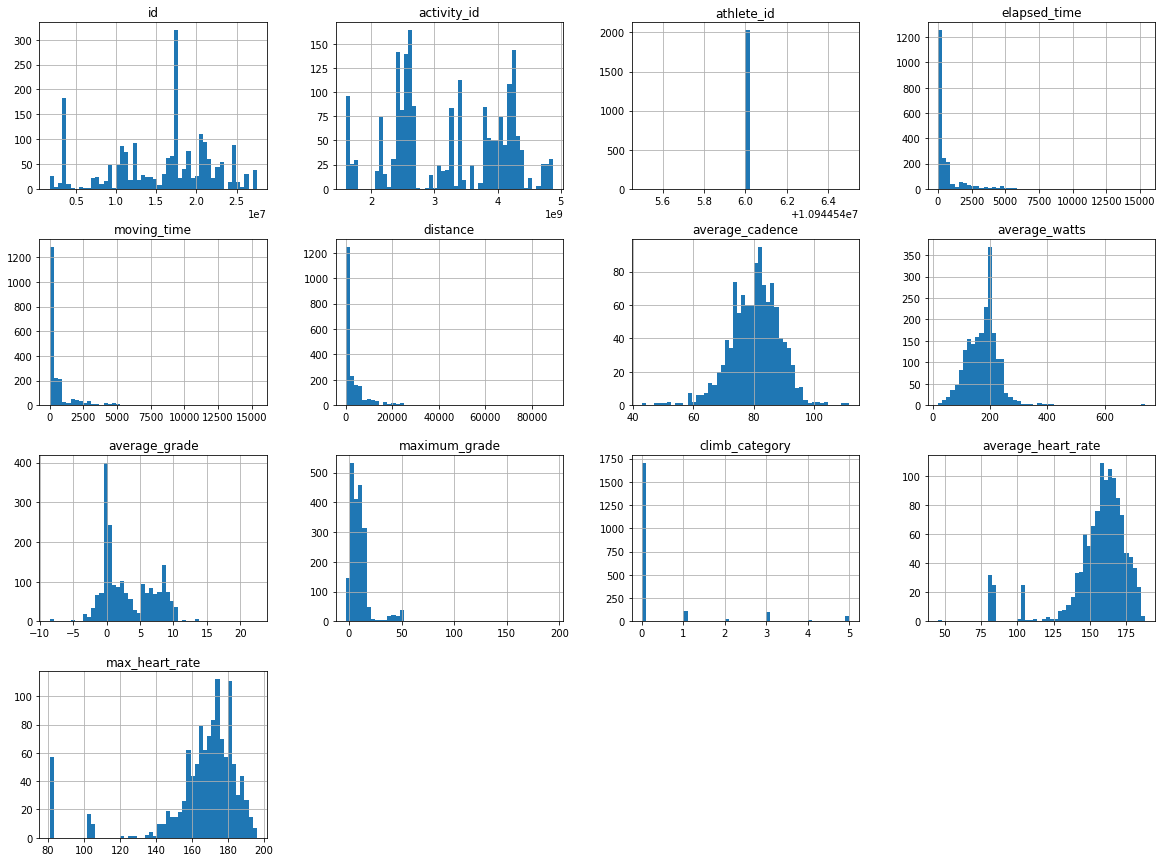

In [15]:
segments_df.hist(bins=50, figsize=(20,15))
plt.show()

* elapsed_time / distance , beaucoup de valeurs abérantes
* Pareil pour maximum_grade avec des % moyen de plus de 30% est ce que toute la donnée est corrompue ?
* Voir aussi pour le heart_rate avec des valeurs a moins de 50...

####  Maximum_grade

Bien que l'information sur le denivelé maximum ne soit pas forcement utile dans le modele , on regarde quand meme ces valeurs extremes...

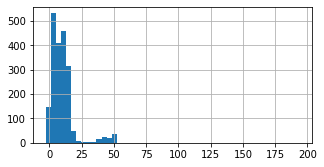

In [16]:
segments_df['maximum_grade'].hist(bins=50, figsize=(5,2.5))
plt.show()

In [17]:
huge_max_grade = segments_df.loc[segments_df['maximum_grade'] > 50]
huge_max_grade.shape

(5, 17)

In [18]:
huge_max_grade['maximum_grade']

183      50.3
877      56.6
885     193.8
996      50.3
1033     50.3
Name: maximum_grade, dtype: float64

In [19]:
huge_max_grade.index

Int64Index([183, 877, 885, 996, 1033], dtype='int64')

On peut imaginer que sur 1m , bien que cela semble énorme , il est possible d'avoir 50% de denivelé , par contre on enleve celui avec 193% de maximum grade

In [20]:
index_to_remove = huge_max_grade.loc[huge_max_grade['maximum_grade'] == 193.8].index[0]
index_to_remove

885

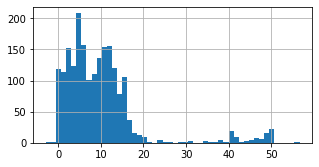

In [21]:
segments_df = segments_df.drop(index_to_remove)
segments_df['maximum_grade'].hist(bins=50, figsize=(5,2.5))
plt.show()


In [22]:
segments_df.shape

(2026, 17)

####  Segments en double dans la meme activité

* segments en double dans la meme activité... ( ex : https://www.strava.com/activities/3198007867) **BUG STRAVA**

In [23]:
segments_double = segments_df[segments_df.duplicated()]
segments_double.shape

(9, 17)

In [24]:
segments_double.head()

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date
987,16784833,3259834962,10944546,Epic KOM,VirtualRide,1831,1831,9410.5,84.2,216.1,3.9,9.0,3,NaN,NaN,18:54:45,2020-04-05
1047,19171748,3198007867,10944546,Rising Empire,VirtualRide,3115,2981,20768.1,76.3,157.6,0.0,16.9,0,NaN,NaN,17:38:53,2020-03-19
1049,19171695,3198007867,10944546,Rising Empire Pens to Banner,VirtualRide,3065,2931,20546.5,76.4,158.1,-0.0,16.6,0,NaN,NaN,17:39:42,2020-03-19
1051,19141090,3198007867,10944546,NYC KOM,VirtualRide,386,386,1367.3,80.7,209.8,6.4,17.9,1,NaN,NaN,17:56:33,2020-03-19
1053,19141092,3198007867,10944546,NYC KOM Reverse,VirtualRide,319,319,1145.1,80.0,195.3,5.9,15.6,0,NaN,NaN,18:17:21,2020-03-19


In [25]:
segments_double_index = segments_double.index
segments_double_index

Int64Index([987, 1047, 1049, 1051, 1053, 1060, 1068, 1070, 1072], dtype='int64')

In [26]:
segments_df = segments_df.drop(segments_double_index)
segments_df.shape

(2017, 17)

In [27]:
segments_df =  segments_df.reset_index(drop=True)

In [28]:
segments_df

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date
0,14270131,4637673624,10944546,Volcano KOM,VirtualRide,654,654,3753.700,76.8,209.3,3.2,11.3,1,177.9,189.0,18:28:18,2021-01-17
1,19970445,4637673624,10944546,Volcano Descent,VirtualRide,281,281,3507.700,64.5,111.1,-3.4,5.9,0,151.6,170.0,18:40:17,2021-01-17
2,22513982,4513379684,10944546,Full Ride,VirtualRide,3407,3351,22343.300,80.2,183.4,1.6,7.5,0,165.2,184.0,18:16:53,2020-12-24
3,23240825,4513379684,10944546,"First 3,5 km",VirtualRide,763,707,3664.300,78.2,179.8,3.3,5.0,1,151.0,171.0,18:16:53,2020-12-24
4,22745156,4513379684,10944546,rouby - les gorges de la nesque,VirtualRide,3183,3127,19504.800,80.1,186.8,2.2,7.8,0,165.5,184.0,18:16:53,2020-12-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,17782861,1597380847,10944546,RadarStadeMartillac,Ride,40,40,303.400,NaN,189.4,1.4,1.6,0,176.8,182.0,12:42:52,2018-05-26
2013,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,Ride,90,90,541.374,NaN,158.9,2.0,5.5,0,183.6,188.0,12:47:30,2018-05-26
2014,3752963,1597380847,10944546,Imitationberg,Ride,141,141,872.000,NaN,82.3,-0.0,5.6,0,168.2,184.0,12:53:34,2018-05-26
2015,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,Ride,226,226,1431.800,NaN,84.4,-0.6,21.7,0,155.2,186.0,12:56:14,2018-05-26


### Comment traiter le cas ou un segment est un ensemble de plusieurs autres segments ? 

- ne pas mettre dans le train et le test des segments avec la meme date

### Segments trop longs ( totalité du parcours... )

In [29]:
too_long_index = segments_df.loc[(segments_df['distance'] > 25000)].index
too_long_index

Int64Index([193, 194, 199, 222, 229, 230, 420, 498, 528, 651, 700, 1849, 1852,
            1857],
           dtype='int64')

In [30]:
segments_df = segments_df.drop(too_long_index)
segments_df =  segments_df.reset_index(drop=True)

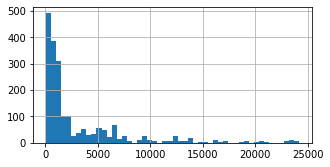

In [31]:
segments_df['distance'].hist(bins=50, figsize=(5,2.5))
plt.show()

## Heart rate

In [32]:
wrong_heartrate_index = segments_df.loc[(segments_df['average_heart_rate'] < 100)].index


In [33]:
segments_df.loc[wrong_heartrate_index]

,id,activity_id,athlete_id,name,type,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date
177,11267167,4328198630,10944546,FIRST CRUEL 100 METERS,VirtualRide,76,76,168.200,78.0,152.4,8.4,20.2,0,45.5,122.0,18:26:11,2020-11-12
1217,22501195,2632652977,10944546,Villenave-Technopole,Ride,652,652,5100.500,NaN,156.8,0.5,6.4,0,81.0,81.0,15:32:38,2019-08-19
1218,3566434,2632652977,10944546,Col du Chateau d'eau,Ride,177,177,1190.370,NaN,197.2,2.1,7.3,0,81.0,81.0,15:33:45,2019-08-19
1219,20598228,2632652977,10944546,Col du chateau d'eau court,Ride,116,116,745.400,NaN,203.9,2.8,5.5,0,81.0,81.0,15:34:53,2019-08-19
1220,10489169,2632652977,10944546,Rien à foutre,Ride,173,173,1399.100,NaN,150.1,0.5,4.9,0,81.0,81.0,15:38:16,2019-08-19
1221,1731538,2632652977,10944546,"""Voie Romaine""",Ride,788,788,6800.290,NaN,153.1,0.0,3.6,0,81.0,81.0,15:41:58,2019-08-19
1222,20526434,2632652977,10944546,DébutVoieRomaine,Ride,230,230,1897.100,NaN,152.1,0.3,2.6,0,81.0,81.0,15:42:15,2019-08-19
1223,19006401,2632652977,10944546,Technopole Romaine aller,Ride,652,652,5630.500,NaN,148.0,-0.1,4.8,0,81.0,81.0,15:43:45,2019-08-19
1224,10540418,2632652977,10944546,Dernier km voie romaine,Ride,112,112,1092.200,NaN,189.1,-0.6,0.0,0,81.0,81.0,15:52:54,2019-08-19
1225,3453075,2632652977,10944546,Faux plat vers Peyron,Ride,472,472,3670.000,NaN,130.7,0.1,4.8,0,82.0,82.0,15:55:36,2019-08-19


In [34]:
segments_df = segments_df.drop(wrong_heartrate_index)
segments_df =  segments_df.reset_index(drop=True)

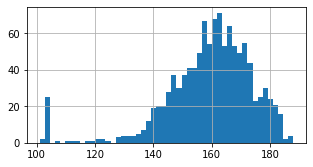

In [35]:
segments_df['average_heart_rate'].hist(bins=50, figsize=(5,2.5))
plt.show()

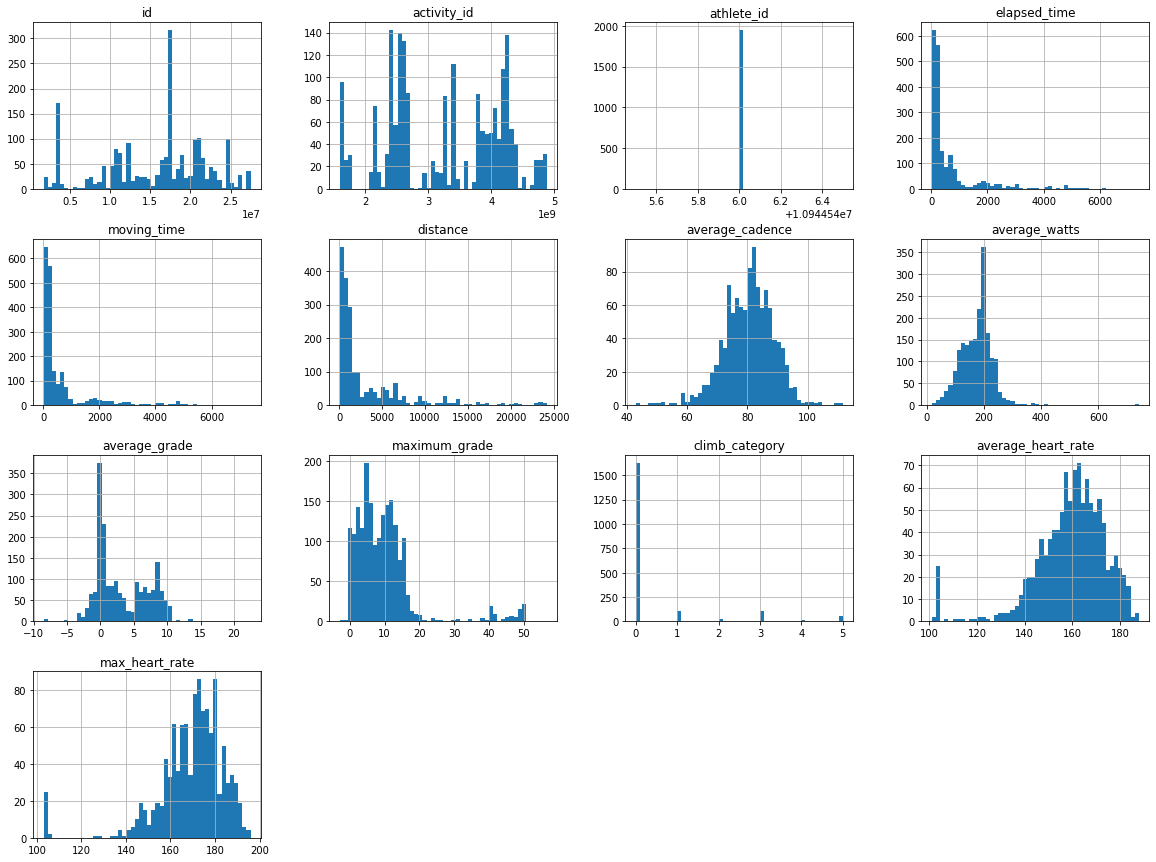

In [36]:
segments_df.hist(bins=50, figsize=(20,15))
plt.show()

In [37]:
segments_df.shape

(1945, 17)